### Pendulum: One-pfive step Method + Gradient Descent

In [1]:
import sys
#sys.path.append('/home/juanfelipe/Desktop/research/keql/source')
sys.path.append('/Users/yasaminjalalian/Repos/keql/source')

In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from parameter_learning import * 
from plotlib import *
from models import * 
from kernels import *
from data_loader import *
from loss import *
from utils import *

import jax
import jax.numpy as jnp
from jax import grad, jit
from jax.scipy.optimize import minimize

from functools import partial # for jit to make codes faster

In [3]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

from jax.config import config; 
config.update("jax_enable_x64", True)

In [4]:
model = 'pendulum'

In [5]:
# Import values from 2-step
two_step_dict = np.load('data/two_step_dict.npy', allow_pickle=True)
two_step_dict = two_step_dict.item()

In [6]:
two_step_dict

{'optim_sgm_u': array([0.14840741, 0.88888889, 0.88888889]),
 'optim_nugget_u': array([1.e-14, 1.e-08, 1.e-14]),
 'rkhs_u': [1.1833129901359858, 10.115344144667745, 136.21275744971464],
 'optim_sgm_P': 0.8152750039562016,
 'optim_nugget_P': 1e-08,
 'nugget_P': 1e-07,
 'rkhs_P': 4038.900702619145,
 'f_pred_test': array([  4.52012592,   6.21651415,   7.78734153,   0.0677476 ,
        -13.1670231 , -10.84996918,  10.14056579,  38.04548527,
         24.77680788,   4.03514364,   2.39721262,   2.15514416,
          2.18068307,   2.53098877,   3.19260485,   4.06413591,
          4.96255826,   5.66164536,   5.95623916,   5.73084622,
          3.45693687,   3.49929028,   3.9472561 ,   4.93767004,
          6.38396929,   7.94897049,   9.13204699,   9.36459357,
          8.12846995,   5.23276092])}

### Cost function

Create objective function `L`

$$
L(Z_0) = f(X_N)^T \Gamma(S_N,S_N)^{-1} f(X_N) + \lambda \sum_{i=1}^m (Z_{0,i*N:(i+1)*N})^T K(X_N,X_N)^{-1}(Z_{0,i*N:(i+1)*N})
$$
where
$$
Z_0[M] = U[M].
$$

1. Test by M = [True].

In [7]:
def L(Z, X, U, M, f, two_step_dict, lmbd):
    """Cost function for 1.5-step method.
    
    Args:
        Z: Vector [Z^1 Z^2 Z^3]^T. m*N
        X: List of mN points of dimension d.
        U: List of N1+N2+N3 values of functions u^(1),...u^(N).
        M: Bolean array which contains where true values reside.
        f: List of mN values of functions u^(1),...u^(N).
        two_step_dict: Dictionary with values from 2-step.
        lmbd: Lagrange multiplier in the loss function.
    Returns:
        scalar: a cost of this solution.    
    """ 

    ### Set up
    N = 10 
    m = 3 
    #print('Z:', Z)
    # Constrain the value of Z with known info
    #Z = jnp.where(M, U, Z)
    # Just use Z_warm instead of using line 21.
    # Cd + 1 = 4
    S = jnp.zeros((N*m,4))
    
    # Split Z
    for i in range(m):
        Zi = Z[i*N:(i+1)*N]
        optim_sgm = two_step_dict.get('optim_sgm_u')[i]
        optim_nugget = two_step_dict.get('optim_nugget_u')[i]
        G = K(Gaussian, X[:N], X[:N], optim_sgm) 
        alphas = jnp.linalg.solve(G + optim_nugget*jnp.eye(N),Zi)

        Zi_x = jnp.dot(K_dot(Gaussian, X[:N], X[:N], optim_sgm, 0), alphas)
        Zi_xx = jnp.dot(K_2dot(Gaussian, X[:N], X[:N], optim_sgm, 0,0), alphas)

        Si = jnp.vstack((X[:N],Zi, Zi_x,Zi_xx)).T
        # print shapes and values here
        S = S.at[i*N:(i+1)*N,:].set(Si)
    # Scaling S_N
    scaler_s_train = MinMaxScaler()
    S = scaler_s_train.fit_transform(S)
    # Gamma(S_N,S_N)
    optim_sgm_P = two_step_dict.get('optim_sgm_P') 
    Gamma = K(Gaussian, S, S, optim_sgm_P)
    nugget_P = two_step_dict.get('nugget_P') 
    Gamma = Gamma + nugget_P*jnp.eye(jnp.size(Gamma,0))
    #print("cond(Gamma) = ", jnp.linalg.cond(Gamma))

    # (Gamma(S_N,S_N) + alpha_Gamma*I)^-1 * f
    b = jnp.linalg.solve(Gamma,f)

    # First term
    L1 = jnp.dot(f.T , b) / two_step_dict.get('rkhs_P')
    #print('L1: ', L1)

    # Second term
    sigma_K = jnp.array(two_step_dict.get('optim_sgm_u'))
    nugget_K = two_step_dict.get('optim_nugget_u')
    K_XNs = []
    for i in range(m):
        K_XN = K(Gaussian,X[:N],X[:N],sigma_K[i]) 
        K_XNs.append(K_XN + nugget_K[i]*jnp.eye(N))
    
    L2 = 0.
    
    for i in range(m):
        #print('Z_constrained:', Z_warm)
        Zi = Z[i*N:(i+1)*N] # print out each of these and display the graphs here ! 
        c = jnp.linalg.solve(K_XNs[i],Zi)
        #print(K_XNs[i][:5,:5])
        #print(Zi)
        #print(Zi.shape)
        #print(c)
        L2 += jnp.reshape(jnp.dot(Zi.T , c),()) / two_step_dict.get('rkhs_u')[i]
        #print('L2_',i,':',jnp.reshape(jnp.dot(Zi.T , c),()) / two_step_dict.get('rkhs_u')[i] )      
    
    return L1 + lmbd*L2
    

#### Gradient descent

Training data

In [8]:
# First column in Gamma(S_N,S_N)
X = x_test.flatten() # N*m * 1

# Second column in Gamma(S_N,S_N)
U = u_test.T.reshape(N*m,) # N*m * 1

# f(X_N)
#f = f_Test(model,e_test)
f = two_step_dict['f_pred_test']

Initial guess: `Z_warm`

In [9]:
# Load values of U predicted from 2-step
u_pred_test = np.load('data/u_pred_test.npy')
u_x_pred_test = np.load('data/u_x_pred_test.npy')
u_xx_pred_test = np.load('data/u_xx_pred_test.npy')
# Build Z_warm
Z_warm = jnp.array(u_pred_test.T.reshape(N*m,)) 

In [10]:
lmbda = 1e5

In [11]:
L(Z_warm, X, U, M, f, two_step_dict, lmbd=lmbda)

DeviceArray(300001.5862481, dtype=float64)

Initialize the grad functions with `jit` to be efficient

In [12]:
grad_Z = grad(L, argnums=0)

# Run once to trigger JIT compilation.
grad_Z(Z_warm, X, U, M, f, two_step_dict, lmbda)
# Warm start here !!!

DeviceArray([ 3.08269173e+01, -8.27407638e+01,  8.42692156e+01,
             -3.02349214e+01,  7.40307777e+04,  7.98210492e+00,
             -7.15267764e+00, -2.08974800e+05,  4.84229404e+04,
             -7.11664364e-01,  3.32363743e+03, -1.38479461e+04,
              2.22024010e+05,  1.68280196e+05, -1.40899931e+05,
             -3.84025623e+05, -2.84089894e+05,  1.33000122e+05,
              4.41880859e+05, -8.24337278e+04, -1.86820012e+02,
              7.80180906e+04, -5.86256715e+03, -1.05888512e+05,
             -1.79450822e+04,  1.66447241e+04, -1.01942455e+04,
              6.37882386e+04, -8.79406597e+02,  8.46036757e+01],            dtype=float64)

Run the gradient descent for `100` epochs

### Optimization of L

In [13]:
# Load the warm-up
Z = np.copy(Z_warm)

In [14]:
# u_t = u_train.T.reshape(N*m,1)
# # Load true gradients from 2-step
# u_x_train = np.load('data/u_x_train.npy')
# u_xx_train = np.load('data/u_xx_train.npy')
# # Build true Z
# Z_true = np.hstack([u_t, u_x_train.T.reshape(N*m,1),u_xx_train.T.reshape(N*m,1)])

In [15]:
# Only do this for the first time - 
#Z = np.copy(Z_warm)
#Z = np.load('data/Z.npy')

0. Run it for more iterations until it actually converges to a minimum!!!
1. Line search (using $p_k = - \nabla f$) using Armijo condition. Pick $\alpha_k$ such that satisfy the two Wolfe conditions. Test: Loss must always goes down here. 
2. Newton-Armijo.
3. Read Quasi-Newton algorithm in Nocedal, when the Hessian is not PD.  

In [16]:
# mses = []
# S = jnp.zeros((N*m,4))
# kernel = Gaussian
# If trained previously use Z
# if np.all(Z != Z_warm):
#     Z = np.load('data/Z.npy')
# else:
#     Z = np.copy(Z_warm)
Z = np.copy(Z_warm)
learning_rate = 1e-12
for i in range(1000):
    delta_Z = grad_Z(Z, X, U, M, f, two_step_dict, lmbda)
    lr = jnp.linalg.norm(Z)/jnp.linalg.norm(delta_Z)*learning_rate
    Z -= lr * delta_Z
    
    # # Pred
    # for j in range(m):
    #     Zi = Z[j*N:(j+1)*N]
    #     #optim_sgm , optim_lmbd = grid_search_RBF_JAX(X[:N].reshape(N,1),Zi.reshape(-1,1))
    #     optim_sgm , optim_lmbd = 0.5, 1e-4
    #     G = K(kernel, X[:N], X[:N], optim_sgm) 
    #     alphas = jnp.linalg.solve(G + optim_lmbd*jnp.eye(N),Zi)
    #     Zi_x = jnp.dot(K_dot(kernel, X[:N], X[:N], optim_sgm, 0), alphas)
    #     Zi_xx = jnp.dot(K_2dot(kernel, X[:N], X[:N], optim_sgm, 0,0), alphas)
    #     Si = jnp.vstack((X[:N],Zi, Zi_x,Zi_xx)).T
    #     S = S.at[j*N:(j+1)*N,:].set(Si)
    # Spred = S[:,-3:]
    # mse = mean_squared_error(Spred,Z_true)/mean_squared_error(0*Spred,Z_true)
    # mses.append(mse)
    if i % 10 == 0:
        print('iter:', i )
        print('loss: ',L(Z, X, U, M, f, two_step_dict, lmbda))
        #print('mse:', mse)
    
# Save at the end of iterations
#np.save('data/Z.npy',Z)

iter: 0
loss:  300001.5862300035
iter: 10
loss:  300001.5861063895
iter: 20
loss:  300001.5860190572
iter: 30
loss:  300001.5859317657
iter: 40
loss:  300001.58584447583
iter: 50
loss:  300001.5857571872
iter: 60
loss:  300001.58566990105
iter: 70
loss:  300001.5855826173
iter: 80
loss:  300001.5854953358
iter: 90
loss:  300001.5854080552
iter: 100
loss:  300001.5853207776
iter: 110
loss:  300001.58523349714
iter: 120
loss:  300001.585146218
iter: 130
loss:  300001.58505894087
iter: 140
loss:  300001.58497166366
iter: 150
loss:  300001.584884392
iter: 160
loss:  300001.58479711815
iter: 170
loss:  300001.5847098503
iter: 180
loss:  300001.5846225816
iter: 190
loss:  300001.58453531505
iter: 200
loss:  300001.5844480445
iter: 210
loss:  300001.58436077746
iter: 220
loss:  300001.58427351236
iter: 230
loss:  300001.5841862487
iter: 240
loss:  300001.5840989878
iter: 250
loss:  300001.5840117246
iter: 260
loss:  300001.5839244649
iter: 270
loss:  300001.58383720415
iter: 280
loss:  300001

- If it does decrease the loss for 10 steps then look for a different alpha, say alpha bigger than it was to make the algorithm more efficient ( if we find for example a flat region).

In [17]:
np.all(Z_warm==Z)

DeviceArray(False, dtype=bool)

Evaluate `Z`

In [18]:
# Build S_N - Training data
S = jnp.zeros((N*m,4))
kernel = Gaussian
# Split Z
for i in tqdm(range(m)):
    Zi = Z[i*N:(i+1)*N]
    optim_sgm , optim_lmbd = two_step_dict.get('optim_sgm_u')[i], two_step_dict.get('optim_nugget_u')[i]
    G = K(kernel, X[:N], X[:N], optim_sgm) 
    alphas = jnp.linalg.solve(G + optim_lmbd*jnp.eye(N),Zi)
    Zi_x = jnp.dot(K_dot(kernel, X[:N], X[:N], optim_sgm, 0), alphas)
    Zi_xx = jnp.dot(K_2dot(kernel, X[:N], X[:N], optim_sgm, 0,0), alphas)
    Si = jnp.vstack((X[:N],Zi, Zi_x,Zi_xx)).T
    S = S.at[i*N:(i+1)*N,:].set(Si)

# Load gradients from 2-step
u_x_pred_test  = np.load('data/u_x_pred_test.npy')
u_xx_pred_test = np.load('data/u_xx_pred_test.npy')
s_test = np.hstack((x_test.reshape(-1,1),u_test.T.reshape(-1,1),u_x_pred_test.T.reshape(-1,1),u_xx_pred_test.T.reshape(-1,1)))  # 30 * 4
f_train = f_Train(model)
f_test = f_Test(model)
scaler_s_train = MinMaxScaler()
s_train_s = scaler_s_train.fit_transform(S)
s_test_s = scaler_s_train.transform(s_test)

optim_sgm_P, optim_nugget_P = grid_search_RBF(s_train_s,f_test)

krr_optimal_P = KernelRidge(kernel='rbf', alpha = two_step_dict.get('optim_nugget_P'), gamma=1/(2*(two_step_dict.get('optim_sgm_P')**2))) 
krr_optimal_P.fit(s_train_s, f_test) 
f_pred_train = krr_optimal_P.predict(s_train_s) 
f_pred_test = krr_optimal_P.predict(s_test_s)

100%|██████████| 3/3 [00:00<00:00, 13.36it/s]


> fig.suptitle(f'1.5-step method: lr = {learning_rate}, lambda = {lmbda}')

/Users/yasaminjalalian/opt/anaconda3/envs/CG/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


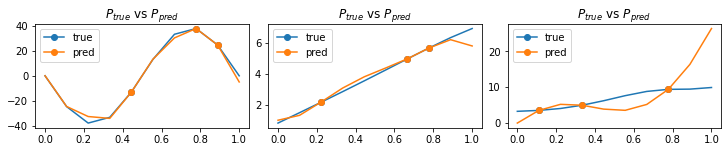

In [20]:
# Plot at testing points
fig, axs = plt.subplots(nrows = 1, ncols=3 , figsize = (10, 2),constrained_layout=True)

axs[0].plot(x_test[:N_test], f_test[:N_test],      marker= 'o', markevery = idx[0], label = 'true')
axs[0].plot(x_test[:N_test], f_pred_test[:N_test], marker= 'o', markevery = idx[0], label = 'pred')
axs[0].legend()
axs[0].set_title('$P_{true}$ vs $P_{pred}$')

axs[1].plot(x_test[N_test:2*N_test], f_test[N_test:2*N_test],      marker= 'o',markevery = idx[1], label = 'true')
axs[1].plot(x_test[N_test:2*N_test], f_pred_test[N_test:2*N_test], marker= 'o',markevery = idx[1], label = 'pred')
axs[1].legend()
axs[1].set_title('$P_{true}$ vs $P_{pred}$')

axs[2].plot(x_test[2*N_test:3*N_test], f_test[2*N_test:3*N_test],      marker= 'o', markevery = idx[2], label = 'true')
axs[2].plot(x_test[2*N_test:3*N_test], f_pred_test[2*N_test:3*N_test], marker= 'o', markevery = idx[2], label = 'pred')
axs[2].legend()
axs[2].set_title('$P_{true}$ vs $P_{pred}$')
fig.show()